# development of evaulation framework for time series imputation methods

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import yaml
from imputation.tools import utilities
from skimage.metrics import structural_similarity as ssim
from fastdtw import fastdtw
from sklearn.metrics.pairwise import cosine_similarity

def load_evaluation_files(data_files: list[str], sep: str) -> tuple[dict, str]:
    """Load working files and files with missing values.

    Args:
        data_files (str): Path to the working file.
        missing_data_files (str): Path to the file with missing values.
    Returns:
        tuple: A tuple containing two dictionaries:
            - Dictionary of working data dataframes.
            - Dictionary of missing data dataframes.
    """
    data = {}

    for file in data_files:
        if file.endswith(".csv"):
            df = pd.read_csv(file, sep=sep, index_col=0)
            set_name = file.strip(".csv").split("/")[-1].split("_")[2:]
            if "missing" in set_name in set_name:
                set_name.remove("missing")
            if "mask" in set_name:
                set_name.remove("mask")
            if "imputed" in set_name:
                set_name.remove("imputed")
            set_name = ("_").join(set_name)
            data[set_name] = df
    prep_method = data_files[0].split("/")[-1].split("_")[1]

    return data, prep_method

def run_evaluation(run: int, 
                   original_data: dict[str, pd.DataFrame], 
                   imputed_data: dict[str, pd.DataFrame], 
                   mask: dict[str, pd.DataFrame], 
                   imputation_method: str, 
                   partition_method: str) -> pd.DataFrame:
    results = pd.DataFrame(columns=["run","imputation_method","partition_method", "station", "feature", "RSME", "MAE", "SSIM", "dtw_distance", "cosine_similarity"])
    for partition in original_data.keys():
        print(f"Evaluating partition: {partition} for method: {imputation_method}\n Data shape: {original_data[partition].shape}, Imputed shape: {imputed_data[partition].shape}")
        if original_data[partition].shape[0]> 7 and original_data[partition].shape[1]>7:
            ssim_score = ssim(original_data[partition].astype(float).values, 
                          imputed_data[partition].astype(float).values, 
                          data_range=max(original_data[partition].max().max(), imputed_data[partition].max().max()) - 
                                     min(original_data[partition].min().min(), imputed_data[partition].min().min())
                                     )
        else:
            ssim_score = np.nan
        for element in original_data[partition].columns:
            # check if there are any missing values to evaluate
            if mask[partition][element].sum() == 0:
                continue
            else:
                original_series = original_data[partition][element]
                imputed_series = imputed_data[partition][element]
                mask_series = mask[partition][element]
                rmse = np.sqrt(np.mean(((original_series - imputed_series)[mask_series == 1]) ** 2))
                mae = np.mean(np.abs((original_series - imputed_series)[mask_series == 1]))
                dtw_distance, _ = fastdtw(original_series[mask_series == 1], imputed_series[mask_series == 1])
                cos_sim = cosine_similarity(original_series[mask_series == 1].values.reshape(1, -1), imputed_series[mask_series == 1].values.reshape(1, -1))[0][0]
                results = pd.concat([results, pd.DataFrame({"run": [run],
                                                        "imputation_method": [imputation_method],
                                                        "partition_method": [partition_method],
                                                        "station": [element if partition_method == "feature" else partition],
                                                        "feature": [element if partition_method == "station" else partition],
                                                        "RSME": [rmse],
                                                        "MAE": [mae],
                                                        "SSIM": [ssim_score],
                                                        "dtw_distance": [dtw_distance],
                                                        "cosine_similarity": [cos_sim]
                                                    })])
    return results

#def main():

#if len(sys.argv) != 3:
#    print("Usage: python3 evaluate_imputations.py <input_dir> <output_dir>")
#    sys.exit(1)
input_dir = "../data/05_imputed"#sys.argv[1]
output_dir = "../data/06_evaluation"#sys.argv[2]


In [ ]:

files = os.listdir(input_dir)
with open(os.path.join(input_dir, "file_list.yaml"), 'r') as file:
    data_files = yaml.safe_load(file)

data_files = ["../"+ f for f in data_files]

with open(os.path.join(input_dir, "file_list_mask.yaml"), 'r') as file:
    mask_files = yaml.safe_load(file)

mask_files = ["../"+ f for f in mask_files]

print(data_files)
methods = [f for f in files if (not f.startswith(".") and not f.endswith(".csv") and not f.endswith(".yaml"))]
data_files_imputed = {}
for method in methods:
    method_dir = os.path.join(input_dir, method)
    method_files = [os.path.join(method_dir, f) for f in os.listdir(method_dir) if (not f.startswith(".") and f.endswith(".csv"))]
    data_files_imputed[method] = method_files

data, mask, partition_method = utilities.load_working_files(data_files=data_files,missing_data_files=mask_files)

imputed_data_iter = iter(data_files_imputed.keys())
imputed_data = {}
for method in imputed_data_iter:
    temp_data, _ = load_evaluation_files(data_files=data_files_imputed[method], sep=',')
    imputed_data[method] = temp_data
imputed_data
results = pd.read_csv(os.path.join(output_dir, "evaluation_results.csv"))
run = results['run'].max() + 1

for imp_method in imputed_data.keys():
    print(f"Evaluating method: {imp_method}")
    temp_results = run_evaluation(run=run, original_data=data, imputed_data=imputed_data[imp_method], mask=mask, imputation_method=imp_method, partition_method=partition_method)
    results = pd.concat([results, temp_results], ignore_index=True)


os.makedirs(output_dir, exist_ok=True)
results.to_csv(os.path.join(output_dir, "evaluation_results.csv"), index=False)

tmp = results[results['run'] == run]
tmp = tmp.groupby(["imputation_method", tmp["partition_method"].unique()[0]]).mean(numeric_only=True).reset_index()
metrics = tmp.columns.tolist()[2:]
import matplotlib.pyplot as plt
import seaborn as sns
for m in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(data=tmp, x=tmp.columns[1], y=m, hue="imputation_method")
    plt.title(f"Comparison of imputation methods based on {m}")
    plt.ylabel(m)
    plt.xlabel(tmp.columns[1])
    plt.legend(title="Imputation Method")
    plt.savefig(os.path.join(output_dir, f"comparison_{m}_{run}.png"))

In [8]:
results = pd.read_csv(os.path.join(output_dir, "evaluation_results.csv"))

In [5]:
1 if np.isnan(results['run'].max()) else results['run'].max()  + 1

1

In [22]:
results.melt(id_vars=["run","imputation_method","partition_method","station","feature"], 
            value_vars=["RSME", "MAE", "SSIM", "dtw_distance", "cosine_similarity"],
            var_name="metric",
            value_name="value").pivot_table(index=["run","partition_method","station","feature","metric"], values="value", aggfunc="mean", columns=["imputation_method"]).reset_index()

imputation_method,run,partition_method,station,feature,metric,brits,ffill,interpolation,iterative,knn,mean,saits,xgboost
0,1,feature,11505_REUTTE,Air_pressure,MAE,2.550321e+02,10.132983,7.250612,7.418429,3.565080,7.418429,8.067386,3.066573
1,1,feature,11505_REUTTE,Air_pressure,RSME,3.670488e+02,12.818864,9.883021,9.439659,4.547705,9.439659,10.245687,4.343934
2,1,feature,11505_REUTTE,Air_pressure,SSIM,3.075293e-01,0.974459,0.977729,0.989296,0.999210,0.989296,0.988782,0.999391
3,1,feature,11505_REUTTE,Air_pressure,cosine_similarity,9.287645e-01,0.999933,0.999948,0.999951,0.999988,0.999951,0.999951,0.999989
4,1,feature,11505_REUTTE,Air_pressure,dtw_distance,1.855720e+06,39263.100000,42730.820048,54992.811016,13805.260000,54992.811016,59821.641530,14347.311328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,4,feature,Day,Wind_speed,MAE,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
946,4,feature,Day,Wind_speed,RSME,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
947,4,feature,Day,Wind_speed,SSIM,7.660022e-01,0.806420,0.810704,0.851932,0.875347,0.851932,0.842952,0.880852
948,4,feature,Day,Wind_speed,cosine_similarity,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
results[results['run']==1]

,run,imputation_method,partition_method,station,feature,RSME,MAE,SSIM,dtw_distance,cosine_similarity
0,1,mean,feature,5904_WIEN-HOHE,Air_pressure,0.139569,0.108502,0.808548,765.919100,0.974224
1,1,mean,feature,5925_WIEN-INNERE,Air_pressure,0.123343,0.094244,0.808548,6413.110571,0.980252
2,1,mean,feature,3202_LINZ-STADT,Air_pressure,0.115020,0.088328,0.808548,5104.388010,0.983734
3,1,mean,feature,4305_ZWERNDORF,Air_pressure,0.115590,0.084006,0.808548,4.872341,0.987488
4,1,mean,feature,12504_BISCHOFSHOFEN,Air_pressure,0.156456,0.125989,0.808548,853.447384,0.971151
...,...,...,...,...,...,...,...,...,...,...
355,1,brits,feature,12504_BISCHOFSHOFEN,Wind_direction,0.278793,0.208598,0.742603,1859.872537,0.853223
356,1,brits,feature,5316_AMSTETTEN,Wind_direction,0.406053,0.326711,0.742603,5817.060077,0.741784
357,1,brits,feature,11505_REUTTE,Wind_direction,0.511856,0.426210,0.742603,15826.746603,0.643228
358,1,brits,feature,7604_WR.NEUSTADT/FLUGPLATZ,Wind_direction,0.271585,0.208122,0.742603,6916.483328,0.912027


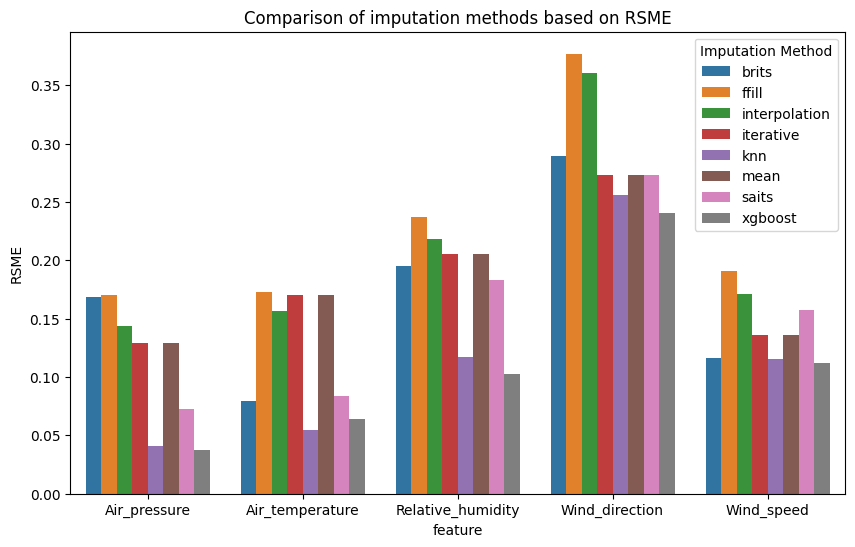

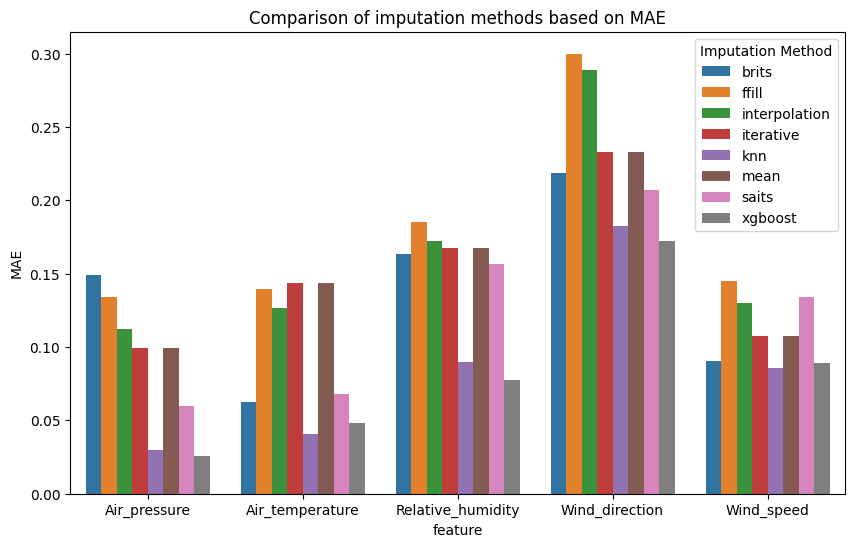

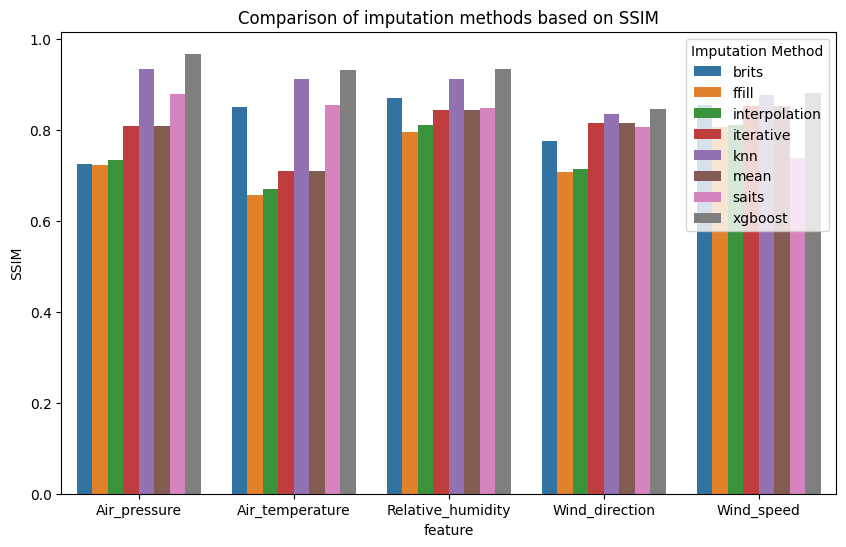

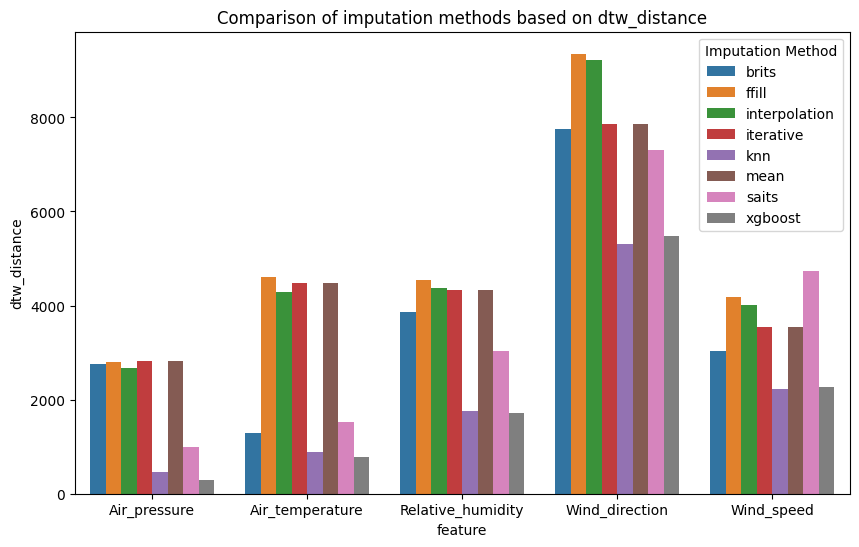

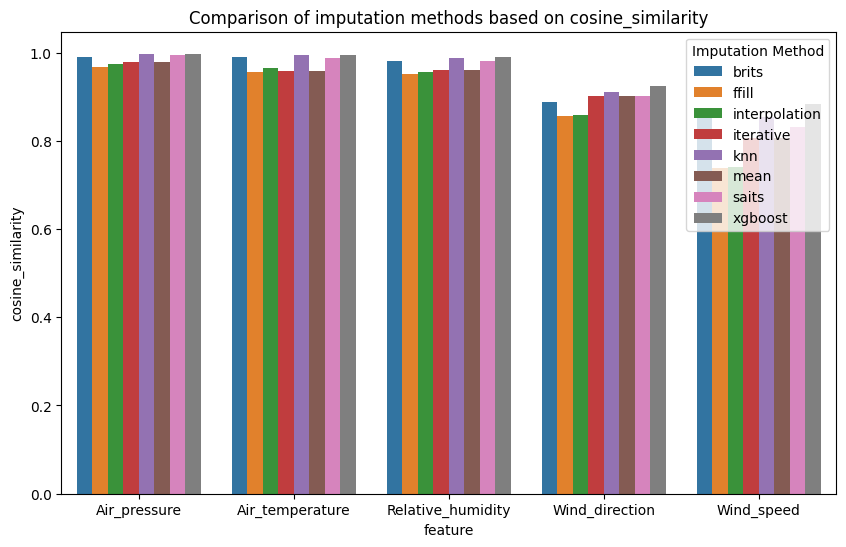

In [11]:
#tmp = results[results['run'] == 1]
partition_method = results["partition_method"].unique()[0]
tmp = results[results['run'] == 1].groupby(["imputation_method", partition_method]).mean(numeric_only=True).reset_index()
metrics = tmp.columns.tolist()[3:]
import matplotlib.pyplot as plt
import seaborn as sns
for m in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(data=tmp, x=tmp.columns[1], y=m, hue="imputation_method")
    plt.title(f"Comparison of imputation methods based on {m}")
    plt.ylabel(m)
    plt.xlabel(partition_method)
    plt.legend(title="Imputation Method")
    plt.show()

In [14]:
#results = pd.DataFrame(columns=["run","imputation_method","partition_method", "station", "feature", "RSME", "MAE", "SSIM", "dtw_distance", "cosine_similarity"])
results = pd.read_csv("../data/06_evaluation/evaluation_results.csv")

In [15]:
from skimage.metrics import structural_similarity as ssim
from fastdtw import fastdtw
from sklearn.metrics.pairwise import cosine_similarity

def run_evaluation(run: int, 
                   original_data: dict[str, pd.DataFrame], 
                   imputed_data: dict[str, pd.DataFrame], 
                   mask: dict[str, pd.DataFrame], 
                   imputation_method: str, 
                   partition_method: str) -> pd.DataFrame:
    results = pd.DataFrame(columns=["run","imputation_method","partition_method", "station", "feature", "RSME", "MAE", "SSIM", "dtw_distance", "cosine_similarity"])
    for partition in original_data.keys():
        print(f"Evaluating partition: {partition} for method: {imputation_method}\n Data shape: {original_data[partition].shape}, Imputed shape: {imputed_data[partition].shape}")
        if original_data[partition].shape[0]> 7 and original_data[partition].shape[1]>7:
            ssim_score = ssim(original_data[partition].astype(float).values, 
                          imputed_data[partition].astype(float).values, 
                          data_range=max(original_data[partition].max().max(), imputed_data[partition].max().max()) - 
                                     min(original_data[partition].min().min(), imputed_data[partition].min().min())
                                     )
        else:
            ssim_score = np.nan
        for element in original_data[partition].columns:
            original_series = original_data[partition][element]
            imputed_series = imputed_data[partition][element]
            mask_series = mask[partition][element]
            rmse = np.sqrt(np.mean(((original_series - imputed_series)[mask_series == 1]) ** 2))
            mae = np.mean(np.abs((original_series - imputed_series)[mask_series == 1]))
            dtw_distance, _ = fastdtw(original_series[mask_series == 1], imputed_series[mask_series == 1])
            cos_sim = cosine_similarity(original_series[mask_series == 1].values.reshape(1, -1), imputed_series[mask_series == 1].values.reshape(1, -1))[0][0]
            results = pd.concat([results, pd.DataFrame({"run": [run],
                                                       "imputation_method": [imputation_method],
                                                       "partition_method": [partition_method],
                                                       "station": [element if partition_method == "feature" else partition],
                                                       "feature": [element if partition_method == "station" else partition],
                                                       "RSME": [rmse],
                                                       "MAE": [mae],
                                                       "SSIM": [ssim_score],
                                                       "dtw_distance": [dtw_distance],
                                                       "cosine_similarity": [cos_sim]
                                                   })])
    return results

In [16]:
partition_method

'feature'

In [17]:
imputed_data.keys()

dict_keys(['ffill', 'mean', 'interpolation', 'knn', 'xgboost', 'iterative', 'saits', 'brits'])

In [18]:
for imp_method in imputed_data.keys():
    print(f"Evaluating method: {imp_method}")
    temp_results = run_evaluation(2, original_data=data, imputed_data=imputed_data[imp_method], mask=mask, imputation_method=imp_method, partition_method=partition_method)
    results = pd.concat([results, temp_results], ignore_index=True)

Evaluating method: ffill
Evaluating partition: Wind_direction for method: ffill
 Data shape: (87648, 12), Imputed shape: (87648, 12)


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by check_pairwise_arrays.

In [ ]:
results

,run,imputation_method,partition_method,station,feature,RSME,MAE,SSIM,dtw_distance,cosine_similarity
0,1,mean,feature,5904_WIEN-HOHE WARTE,Wind_speed,2.047881,1.607828,0.796784,1.249877e+05,0.852934
1,1,mean,feature,5925_WIEN-INNERE STADT,Wind_speed,1.793653,1.448452,0.796784,4.635337e+04,0.867701
2,1,mean,feature,3202_LINZ-STADT,Wind_speed,0.646702,0.505345,0.796784,1.605178e+04,0.821403
3,1,mean,feature,4305_ZWERNDORF,Wind_speed,2.264823,1.852304,0.796784,4.135640e+04,0.808787
4,1,mean,feature,12504_BISCHOFSHOFEN,Wind_speed,1.276774,0.939298,0.796784,2.395399e+04,0.702785
...,...,...,...,...,...,...,...,...,...,...
795,2,brits,station,5925_WIEN-INNERE_STADT,Wind_direction,236.808711,219.733212,NaN,7.029503e+06,0.219514
796,2,brits,station,5925_WIEN-INNERE_STADT,Relative_humidity,67.118285,65.112174,NaN,2.072633e+06,0.312856
797,2,brits,station,5925_WIEN-INNERE_STADT,Air_pressure,992.327140,992.192373,NaN,3.175214e+07,0.211733
798,2,brits,station,5925_WIEN-INNERE_STADT,Air_temperature,284.048502,283.819047,NaN,9.082777e+06,0.269607


In [42]:
# aggregate results by feature and imputation method
agg_results = results.groupby(["imputation_method","station"])[["RSME", "MAE", "SSIM", "dtw_distance", "cosine_similarity"]].mean()

In [43]:
agg_results

RSME         MAE      SSIM  \
imputation_method station                                               
brits             Air_pressure       405.871325  332.653790  0.307529   
                  Air_temperature    108.508616   89.629942  0.463531   
                  Relative_humidity   17.960582   14.551404  0.786222   
                  Wind_direction     130.784304  108.915690  0.562143   
                  Wind_speed           1.530209    1.171023  0.740361   
ffill             Air_pressure        10.856209    8.645552  0.974459   
                  Air_temperature     10.140654    8.310980  0.503024   
                  Relative_humidity   19.647020   15.060547  0.726459   
                  Wind_direction     134.759181  105.607661  0.684068   
                  Wind_speed           2.204843    1.661674  0.709154   
interpolation     Air_pressure         9.542767    7.571793  0.977729   
                  Air_temperature      9.552506    7.834205  0.503710   
                  Relative_humidity   19.352930   15.111812  0.723787   
                  Wind_direction     130.481632  104.102859  0.686710   
                  Wind_speed           2.229552    1.661378  0.696538   
iterative         Air_pressure         8.266912    6.363733  0.989296   
                  Air_temperature      9.598049    8.115126  0.584960   
                  Relative_humidity   17.756261   14.639716  0.744182   
                  Wind_direction     102.226130   85.953727  0.748622   
                  Wind_speed           1.679039    1.320349  0.796784   
knn               Air_pressure         1.852087    1.429804  0.999210   
                  Air_temperature      2.921032    2.212244  0.911644   
                  Relative_humidity   13.645892   10.730074  0.853651   
                  Wind_direction     104.059647   80.756880  0.748187   
                  Wind_speed           1.706823    1.312487  0.782660   
mean              Air_pressure         8.266912    6.363733  0.989296   
                  Air_temperature      9.598049    8.115126  0.584960   
                  Relative_humidity   17.756261   14.639716  0.744182   
                  Wind_direction     102.226130   85.953727  0.748622   
                  Wind_speed           1.679039    1.320349  0.796784   
saits             Air_pressure         8.773951    6.827568  0.988782   
                  Air_temperature     10.672321    9.131007  0.559612   
                  Relative_humidity   14.478471   10.712697  0.864049   
                  Wind_direction     103.470011   82.966600  0.764279   
                  Wind_speed           1.571429    1.125273  0.810808   
xgboost           Air_pressure         1.650398    1.144350  0.999391   
                  Air_temperature      2.723163    2.001307  0.930911   
                  Relative_humidity    9.981887    7.631527  0.897966   
                  Wind_direction      92.571274   69.240141  0.788880   
                  Wind_speed           1.407277    1.112389  0.828591   

                                     dtw_distance  cosine_similarity  
imputation_method station                                             
brits             Air_pressure       9.994437e+06           0.942508  
                  Air_temperature    2.672599e+06           0.955842  
                  Relative_humidity  3.114593e+05           0.980436  
                  Wind_direction     4.191297e+06           0.711822  
                  Wind_speed         3.927132e+04           0.820689  
ffill             Air_pressure       2.036757e+05           0.999947  
                  Air_temperature    2.372503e+05           0.999466  
                  Relative_humidity  3.832803e+05           0.972516  
                  Wind_direction     3.301002e+06           0.866007  
                  Wind_speed         5.494714e+04           0.680088  
interpolation     Air_pressure       1.984492e+05           0.999957  
                  Air_temperature    2.344553e+05    

In [ ]:
imputed_data["mean"]

dict_keys(['Wind_speed_imputed', 'Wind_direction_imputed', 'Air_pressure_imputed', 'Relative_humidity_imputed', 'Air_temperature_imputed'])

In [21]:
imputed_data["mean"]["Wind_speed"].columns

Index(['5904_WIEN-HOHE WARTE', '5925_WIEN-INNERE STADT', '3202_LINZ-STADT',
       '4305_ZWERNDORF', '12504_BISCHOFSHOFEN', '20212_KLAGENFURT-FLUGHAFEN',
       '5316_AMSTETTEN', '11505_REUTTE', '7604_WR.NEUSTADT/FLUGPLATZ',
       '5972_GROSS-ENZERSDORF'],
      dtype='object')

In [23]:
data["Wind_speed"].columns

Index(['5904_WIEN-HOHE WARTE', '5925_WIEN-INNERE STADT', '3202_LINZ-STADT',
       '4305_ZWERNDORF', '12504_BISCHOFSHOFEN', '20212_KLAGENFURT-FLUGHAFEN',
       '5316_AMSTETTEN', '11505_REUTTE', '7604_WR.NEUSTADT/FLUGPLATZ',
       '5972_GROSS-ENZERSDORF'],
      dtype='object')

In [24]:
mask["Wind_speed"].columns

Index(['5904_WIEN-HOHE WARTE', '5925_WIEN-INNERE STADT', '3202_LINZ-STADT',
       '4305_ZWERNDORF', '12504_BISCHOFSHOFEN', '20212_KLAGENFURT-FLUGHAFEN',
       '5316_AMSTETTEN', '11505_REUTTE', '7604_WR.NEUSTADT/FLUGPLATZ',
       '5972_GROSS-ENZERSDORF'],
      dtype='object')

In [46]:
# switch values between station and feature in the results dataframe they have been mixed up
results["station"], results["feature"] = results["feature"], results["station"]

In [10]:
# save results to ../data/06_evaluation/evaluation_results.csv
# create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
results.to_csv(os.path.join(output_dir, "evaluation_results.csv"), index=False)